<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/COVID_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis estadístico del dataset de COVID-19 proporcionado por la secretaría de salud.

### Objetivos
* Identidicar los factores de los pacientes que aumentan su probabilidad de fallecer o presentar enfermedad grave.
* Identificar si la mortalidad varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si la probabilidad de padecer la enfermedad grave varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si los dias entre el inicio de los sintomas y la atención médica afecta en la mortalidad.
* Conocer si la mortalidad y la positividad cambió en el transcurso de la pandemia.
* Realizar una limpieza y tratamiento de datos para obtener un dataset listo para crear un modelo predictorio de la probabilidad de muerte de un paciente dadas sus características.


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
import sys

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Librería hecha para manejar el dataset de covid
sys.path.insert(1,'/content/drive/MyDrive/Python Scripts/')
import COVID19_MX as covid

## Carga de Dataset principal y auxiliares
Los dataset auxiliares `sexo_df`, `sector_df` y `entidad_df` servirán para usar variables categóricas en el modelo.

In [4]:
aux_dataset_path = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Diccionario%20de%20Datos"
main_dataset_path = "/content/drive/MyDrive/Datos Abiertos"
covid_file = "210401COVID19MEXICO.csv"
sexo_file = "Sexo.csv"
sector_file = "Sector.csv"
entidad_file = "Entidad.csv"

In [5]:
covid_df = pd.read_csv(os.path.join(main_dataset_path,covid_file))
sexo_df = pd.read_csv(os.path.join(aux_dataset_path,sexo_file))
sector_df = pd.read_csv(os.path.join(aux_dataset_path,sector_file))
entidad_df = pd.read_csv(os.path.join(aux_dataset_path,entidad_file))

## Limpieza y Tratamiento de Datos

In [6]:
covid_df.sample(2)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
5726882,2021-04-01,a5875f,2,12,9,1,9,9,7,1,2021-03-11,2021-03-08,9999-99-99,97,2,37,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,97,1,2,7,99,México,97,97
1922268,2021-04-01,2ddcf0,2,9,21,2,20,20,68,1,2020-09-24,2020-09-24,9999-99-99,97,2,24,1,97,2,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,97,7,99,México,97,97


In [7]:
covid_df.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [8]:
covid_df.shape

(6110815, 40)

### Se agrega columna Resultado
**Se agrega la columna de `RESULTADO` para facilitar el análisis** 
* Positivo: 1
* Negativo: 2
* Sospechoso: 3

In [9]:
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(covid.getResult)

In [10]:
covid_df[["CLASIFICACION_FINAL","RESULTADO"]].sample(10)

,CLASIFICACION_FINAL,RESULTADO
2618329,7,2
538770,6,3
457256,6,3
5212809,7,2
5810845,3,1
5468173,7,2
3472608,1,1
3846613,6,3
5590349,7,2
5951881,7,2


In [11]:
date = "2021-04-01"
comulative_cases = covid.getComulativeCases(covid_df)
covid.printCumulativeCases(comulative_cases, date)

Fecha de actualización: 2021-04-01

  Total de casos estudiados: 6110815

  Casos Positivos a SARS-CoV-2: 2244268

  Casos No Positivos a SARS-CoV-2: 3426205

  Casos Con Resultado Pendiente: 440342

  Defunciones Positivas a SARS-CoV-2: 203664

  Tasa de Letalidad: 9.075%

  Tasa de Positividad : 39.578%



### Filtrado de casos con datos incompletos

En el diccionario de datos se identifico que hay valores *no aplica* o *no especificado*, para realizar el análisis hay que eliminar esos valores, ya sea eliminando el caso que los contenga o cambiandolo. El problema es que esos valores están en varias columnas, por lo tanto se tendrá que usar un `for loop`.

In [12]:
# Se filtra el dataset para eliminar casos con información No especificada y se toman solamente los casos positivos.
data_filtered = covid_df[(covid_df["SEXO"] != 99)
& (covid_df["SECTOR"] != 99)
& (covid_df["ENTIDAD_UM"] < 97)
& (covid_df["RESULTADO"] == 1)]

In [13]:
# Se filtran los datos No especificados de las categorias SI-NO (leer el diccionario de datos)
data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])

categorias_si_no = ['INTUBADO','UCI','NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']

for cat in categorias_si_no:
  data_filtered = data_filtered[data_filtered[cat] <= 97]
  data_filtered[cat] = data_filtered[cat].apply(lambda x: 1 if x == 1 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Se eliminan los datos no especificados de la columna TIPO_PACIENTE
data_filtered = data_filtered[data_filtered["TIPO_PACIENTE"] != 99]

In [15]:
data_filtered.shape

(2221525, 41)

Oficialmente hay 2,244,268 casos positivos a SARS-COV-2, pero después del filtrado obtuvimos 2,221,525, hay una diferencia de 22,743 casos, esto se debe a que se eliminaron casos con información incompleta. Por la cantidad de datos esta diferencia es estadísticamente insignificante y no supondrá un problema en el análisis o en la creación del modelo.

In [16]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO
4246605,2021-04-01,d6f29d,2,12,9,2,9,9,12,1,2021-01-04,2020-12-31,9999-99-99,0,0,47,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1
5866780,2021-04-01,ccb907,2,4,9,2,9,9,7,1,2021-03-18,2021-03-16,9999-99-99,0,0,36,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1
722539,2021-04-01,1b438b,1,12,26,1,16,26,70,1,2020-06-30,2020-06-28,9999-99-99,0,0,67,1,0,2,2,0,0,0,0,0,0,0,1,0,0,1,1,1,2,97,3,99,México,97,0,1
3521637,2021-04-01,3947bb,2,6,13,1,13,13,3,1,2020-12-26,2020-12-23,9999-99-99,0,0,35,1,0,2,1,0,0,0,0,0,0,0,0,0,0,1,2,97,1,1,3,99,México,97,0,1
4375323,2021-04-01,538210,2,12,9,2,9,9,11,1,2021-01-22,2021-01-22,9999-99-99,0,0,27,1,0,2,2,0,0,0,0,0,0,0,0,0,0,2,2,97,1,1,3,99,México,97,0,1


### Cambio de tipo de dato de fechas
**Las columnas de `FECHA_SINTOMAS` y `FECHA_INGRESO` correspondientes a la fecha de inicio de sintomas y a la fecha de ingreso a la unidad de atención estan en string, se les cambiará a tipo de dato `datetima` para el manejo de fechas**

In [17]:
data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")

In [18]:
data_filtered["FECHA_SINTOMAS"] = pd.to_datetime(data_filtered["FECHA_SINTOMAS"], format = "%Y-%m-%d")

In [19]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].dtypes

FECHA_INGRESO     datetime64[ns]
FECHA_SINTOMAS    datetime64[ns]
dtype: object

In [20]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].sample(5)

,FECHA_INGRESO,FECHA_SINTOMAS
4255863,2021-01-15,2021-01-15
5985678,2021-01-29,2021-01-22
265342,2020-05-09,2020-05-04
2211540,2020-10-20,2020-10-16
856022,2020-07-10,2020-06-30


### Agregado de columna `TIEMPO_ESPERA`
Se agrega la columna `TIEMPO_ESPERA` que indica el tiempo en días que paso desde el inicio de los sintomas `FECHA_SINTOMAS` y el ingreso a la unidad de salud `FECHA_INGRESO`.

In [21]:
data_filtered["TIEMPO_ESPERA"] = data_filtered["FECHA_INGRESO"] - data_filtered["FECHA_SINTOMAS"]
data_filtered["TIEMPO_ESPERA"] = data_filtered["TIEMPO_ESPERA"].apply(lambda x: x.days)

In [22]:
data_filtered["TIEMPO_ESPERA"].dtypes

dtype('int64')

### Agregado de columna `FALLECIDO`
Esta columna será catagórica, indica si el paciente falleció por covid, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [23]:
data_filtered["FALLECIDO"] = data_filtered["FECHA_DEF"].apply(lambda x: 1 if x != "9999-99-99" else 0)

In [24]:
data_filtered[["FECHA_DEF","FALLECIDO"]].sample(10)

,FECHA_DEF,FALLECIDO
5730377,9999-99-99,0
4195531,9999-99-99,0
1548213,9999-99-99,0
2829406,9999-99-99,0
3265905,9999-99-99,0
1559271,9999-99-99,0
2725967,9999-99-99,0
2904212,9999-99-99,0
1455635,9999-99-99,0
519354,9999-99-99,0


### Agregado de la columna `ENFERMEDAD_GRAVE`
Esta columna será catagórica, indica si el paciente presentó enfermedad grave.

Se considera que un paciente presentó la enfermedad grave si presenta al menos una de las siguientes situaciones:
* El paciente requirió de intubación.
* El paciente fue diagnosticado con neumonía.
* El paciente requirió ingresar a una Unidad de Cuidados Intensivos.

Los valores posibles en esta columna son los siguientes:
* Si: *1*
* No: *0*

In [25]:
data_filtered["ENFERMEDAD_GRAVE"] = np.where((data_filtered["INTUBADO"] == 1) 
| (data_filtered["NEUMONIA"] == 1)
| (data_filtered["UCI"] == 1) , 1, 0)

In [26]:
data_filtered[["NEUMONIA", "INTUBADO", "UCI", "ENFERMEDAD_GRAVE"]].sample(10)

,NEUMONIA,INTUBADO,UCI,ENFERMEDAD_GRAVE
5930426,0,0,0,0
3563853,0,0,0,0
3970382,1,0,0,1
4835527,0,0,0,0
3777286,0,0,0,0
4121972,1,0,0,1
4743854,1,0,0,1
472812,0,0,0,0
713210,0,0,0,0
2551261,0,0,0,0


### Agregado de columna `HOSPITALIZADO`
Esta columna será catagórica, indica si el paciente fue hospitalizado, si esto no es así se asume que el tratamiento del paciente fue embulatorio, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [27]:
data_filtered["HOSPITALIZADO"] = data_filtered["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [28]:
data_filtered[["TIPO_PACIENTE", "HOSPITALIZADO"]].sample(10)

,TIPO_PACIENTE,HOSPITALIZADO
2543224,1,0
5084956,1,0
5544325,1,0
2904369,1,0
5053453,1,0
2553504,1,0
3079181,1,0
2214524,1,0
3972661,1,0
3984709,1,0



### Combinación del dataframe principal con los dataframes auxiliares.

In [29]:
# Se le cambian los nombres de las columnas a los dataframes auxiliares
sexo_df.columns = ["SEXO", "SEXO_"]
sector_df.columns = ["SECTOR", "SECTOR_ATENDIDO"]
entidad_df.columns = ["ENTIDAD_UM","ESTADO"]

In [30]:
data_filtered = pd.merge(data_filtered, sexo_df, how = "inner", on = "SEXO")
data_filtered = pd.merge(data_filtered, sector_df, how = "inner", on = "SECTOR")
data_filtered = pd.merge(data_filtered, entidad_df, how = "inner", on = "ENTIDAD_UM")

In [31]:
data_filtered[["SEXO_","SECTOR_ATENDIDO","ESTADO"]].sample(5)

,SEXO_,SECTOR_ATENDIDO,ESTADO
1499115,MUJER,SSA,ZS
1305796,HOMBRE,IMSS,MC
1138919,MUJER,IMSS,NL
861823,MUJER,SSA,QT
227278,HOMBRE,SSA,DF


## Análisis Exploratorio

En esta sección se obtendrán algunos datos estadísticos que pueden ayudar a comprender el comportamiento de la enfermedad.

In [32]:
# Para esta sección se definio una función para obtener los cartiles
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

### Distribución de edad por sexo de los infectados.

Text(0, 0.5, 'Número de casos confirmados')

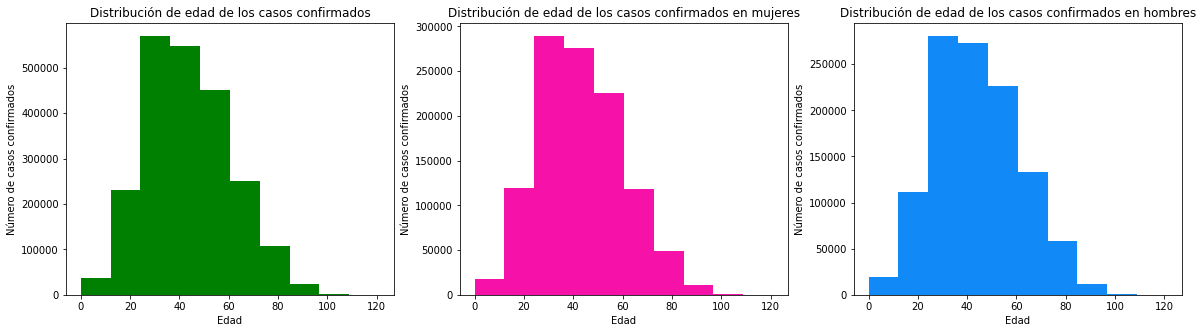

In [33]:
fig, axs = plt.subplots(ncols = 3, nrows = 1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"], color="g")
axs[0].set_title("Distribución de edad de los casos confirmados")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "MUJER"], color="#F611A9")
axs[1].set_title("Distribución de edad de los casos confirmados en mujeres")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

axs[2].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "HOMBRE"], color="#1189F6")
axs[2].set_title("Distribución de edad de los casos confirmados en hombres")
axs[2].set_xlabel("Edad")
axs[2].set_ylabel("Número de casos confirmados")


In [34]:
print("Resumen edad de casos positivos")
age_summary = summary(data_filtered["EDAD"])
age_summary

Resumen edad de casos positivos


{'IQR': 24.0,
 'Q1': 31.0,
 'Q2': 42.0,
 'Q3': 55.0,
 'max': 121,
 'media': 43.71238393103113,
 'mediana': 42.0,
 'minimo': 0}

**Se puede ver que la distribución varía poco entre hombres y mujeres, el 50% de los contagios están entre los 31 y 55 años de edad**

### Distribución de edad en casos hospitalizados y ambulatorios.

Text(0, 0.5, 'Número de casos confirmados')

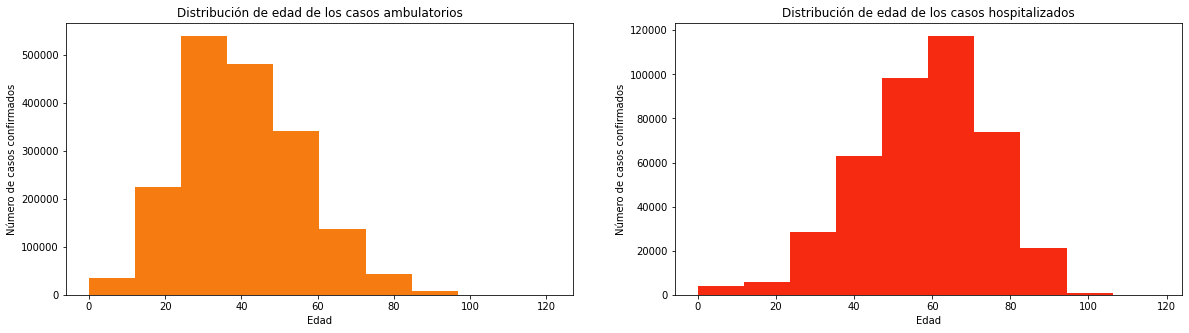

In [35]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0], color="#F67C11")
axs[0].set_title("Distribución de edad de los casos ambulatorios")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1], color="#F62911")
axs[1].set_title("Distribución de edad de los casos hospitalizados")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [36]:
print("Resumen edad de casos ambulatorios")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0])
amb_age

Resumen edad de casos ambulatorios


{'IQR': 22.0,
 'Q1': 29.0,
 'Q2': 39.0,
 'Q3': 51.0,
 'max': 121,
 'media': 40.44257041034878,
 'mediana': 39.0,
 'minimo': 0}

In [37]:
print("Resumen edad de casos hospitalizados")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1])
amb_age

Resumen edad de casos hospitalizados


{'IQR': 22.0,
 'Q1': 48.0,
 'Q2': 59.0,
 'Q3': 70.0,
 'max': 118,
 'media': 58.04067398308985,
 'mediana': 59.0,
 'minimo': 0}

**Se puede apreciar que el grueso de los casos tratados ambulatoriamente están entre los 29 y 51 años de edad mientras que los hospitalizados estan entre los 48 y 70.**

### Distribución por edad de fallecidos

Text(0, 0.5, 'Número de casos confirmados')

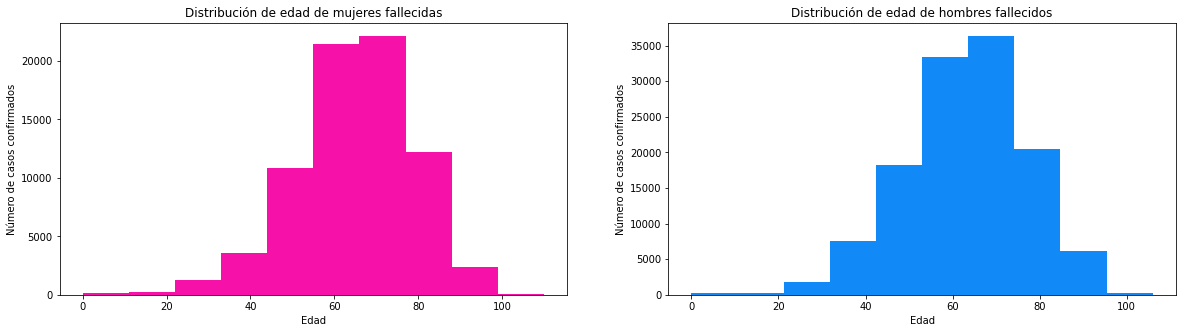

In [38]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)], color="#F611A9")
axs[0].set_title("Distribución de edad de mujeres fallecidas")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)], color="#1189F6")
axs[1].set_title("Distribución de edad de hombres fallecidos")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [39]:
print("Resumen edad en mujeres fallecidas")
female_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)])
female_deceased

Resumen edad en mujeres fallecidas


{'IQR': 18.0,
 'Q1': 56.0,
 'Q2': 65.0,
 'Q3': 74.0,
 'max': 110,
 'media': 64.48083071384434,
 'mediana': 65.0,
 'minimo': 0}

In [40]:
print("Resumen edad en hombres fallecidos")
male_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)])
male_deceased

Resumen edad en hombres fallecidos


{'IQR': 19.0,
 'Q1': 54.0,
 'Q2': 64.0,
 'Q3': 73.0,
 'max': 106,
 'media': 62.94446359707847,
 'mediana': 64.0,
 'minimo': 0}

**El 50% de los fallecidos parece estar entre los 55 y 74 años de edad**

### Comparación de mortalidad en hombres y mujeres

In [41]:
table = pd.crosstab(data_filtered.SEXO_, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table

FALLECIDO,0,1,MORTALIDAD
SEXO_,,,
HOMBRE,990557,124729,0.111836
MUJER,1031796,74442,0.067293


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

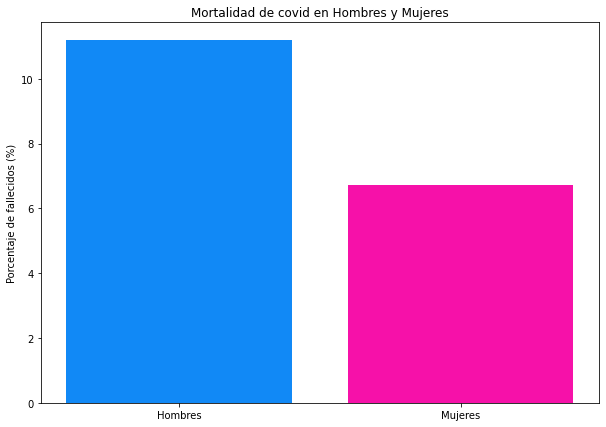

In [42]:
plt.figure(figsize = (10,7))
plt.bar(["Hombres"], table["MORTALIDAD"][0]*100, color = "#1189F6")
plt.bar(["Mujeres"], table["MORTALIDAD"][1]*100, color = "#F611A9")
plt.title("Mortalidad de covid en Hombres y Mujeres")
plt.ylabel("Porcentaje de fallecidos (%)")

## Mortalidad por estado y por sector

### Mortalidad por estado


In [43]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
ESTADO,,,
BS,26919,1244,0.044171
DF,664443,38955,0.055381
TC,57052,3557,0.058688
QT,60960,3989,0.061417
DG,28735,2042,0.066348
OC,39930,3103,0.072107
NL,110864,9067,0.075602
GT,117514,9860,0.077410
SP,55028,4942,0.082408


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

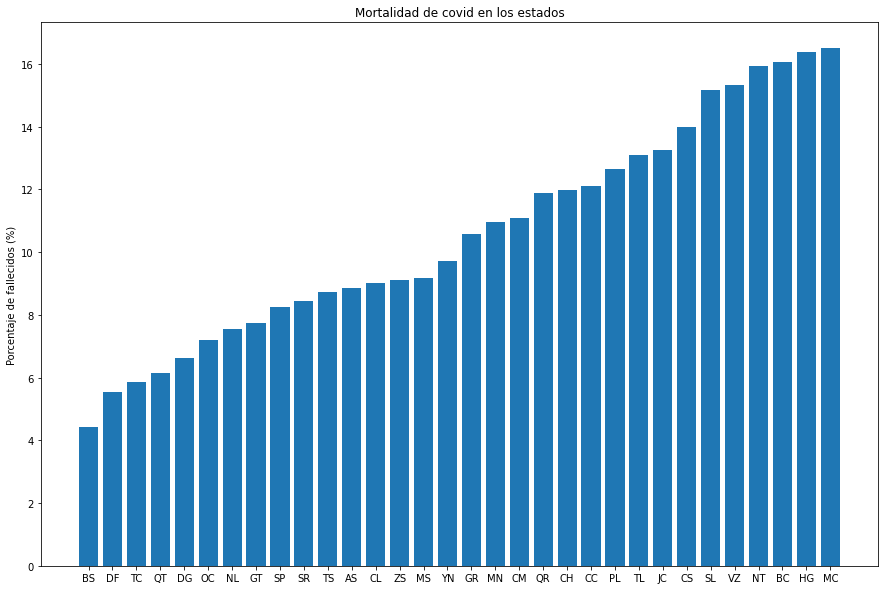

In [44]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid en los estados")
plt.ylabel("Porcentaje de fallecidos (%)")

### Mortalidad por sector de la salud

In [45]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
SECTOR_ATENDIDO,,,
DIF,815,1,0.001225
MUNICIPAL,1617,65,0.038644
SSA,1230078,54979,0.042783
CRUZ ROJA,211,13,0.058036
PRIVADA,54328,3581,0.061838
SEMAR,6679,584,0.080408
ESTATAL,24179,3118,0.114225
IMSS-BIENESTAR,10913,1604,0.128146
SEDENA,12616,2347,0.156854


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

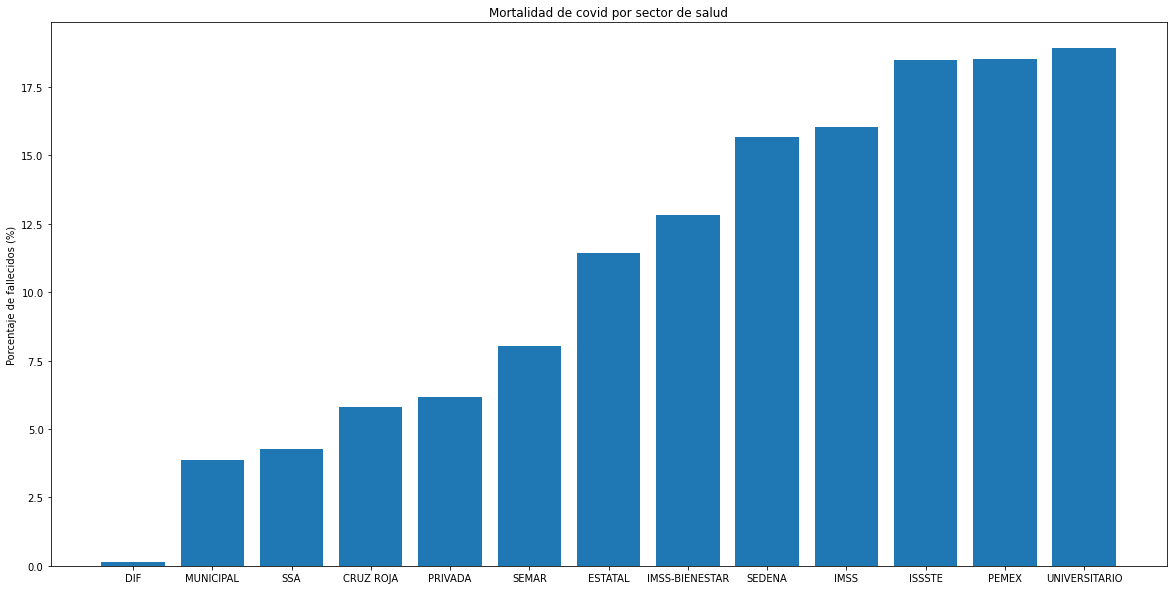

In [46]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid por sector de salud")
plt.ylabel("Porcentaje de fallecidos (%)")

## Proporcion de enfermos grave de covid por estado y por sector

### Proporción de enfermos graves por estado

In [47]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
ESTADO,,,
DG,28857,1920,0.062384
BS,25948,2215,0.078649
DF,633846,69552,0.098880
CL,58824,6518,0.099752
TS,48682,5418,0.100148
TC,54478,6131,0.101157
ZS,25879,2968,0.102888
OC,38148,4885,0.113518
GT,112464,14910,0.117057


Text(0, 0.5, 'Porcentaje de enfermos (%)')

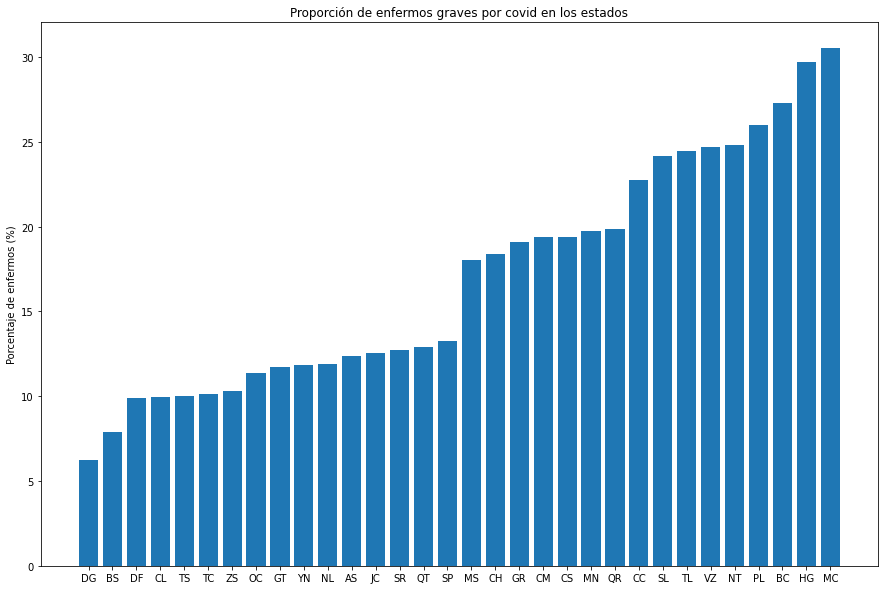

In [48]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por covid en los estados")
plt.ylabel("Porcentaje de enfermos (%)")

### Proporción de enfermos graves por sector de salud

In [49]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
SECTOR_ATENDIDO,,,
DIF,790,26,0.031863
CRUZ ROJA,204,20,0.089286
SSA,1166935,118122,0.091920
MUNICIPAL,1457,225,0.133769
IMSS,575259,140764,0.196591
IMSS-BIENESTAR,9693,2824,0.225613
PRIVADA,44454,13455,0.232347
SEMAR,5534,1729,0.238056
SEDENA,11178,3785,0.252957


Text(0, 0.5, 'Porcentaje de enfermos graves (%)')

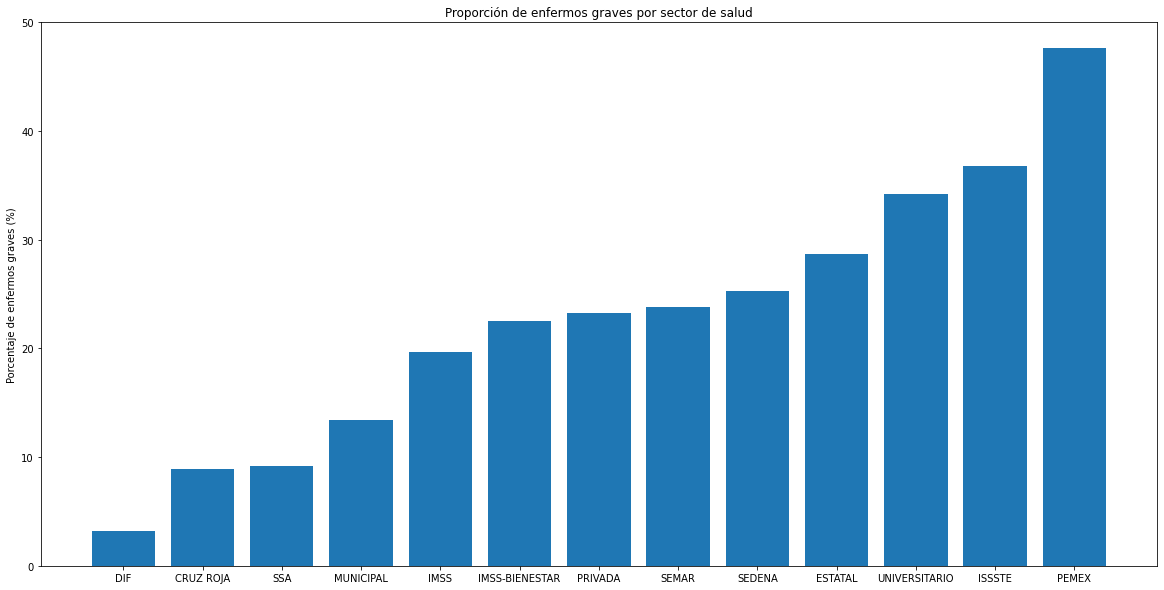

In [115]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por sector de salud")
plt.ylabel("Porcentaje de enfermos graves (%)")

## Mortalidad por días de espera
Se obtendrá la mortalidad según los días entre que el paciente presento síntomas y cuando se atendió en una unidad de salud.

Text(0, 0.5, 'Porcentaje de fallecidos (%)')

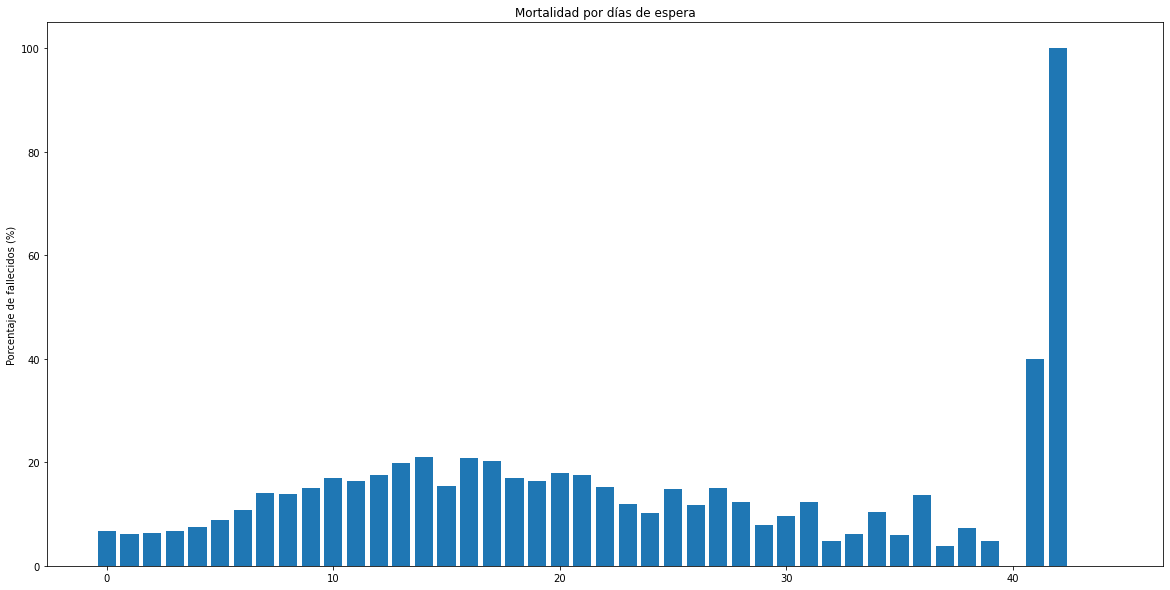

In [125]:
table = pd.crosstab(data_filtered.TIEMPO_ESPERA, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["TIEMPO_ESPERA"])
table = table[0:45]

plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad por días de espera")
plt.ylabel("Porcentaje de fallecidos (%)")

Se puede ver que no necesariamente aumenta la mortalidad entre más días de espera.

##  Mortalidad y Positividad a lo largo de la pandemia
Se obtendrá la mortalidad y positividad por semana desde la primera semana del 2020 (Se registraban solamente casos sospechosos los primeros meses del 2020)

In [57]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(covid_df, dates)
cases_by_day = pd.DataFrame(cases_by_day)

### Gráfica de casos


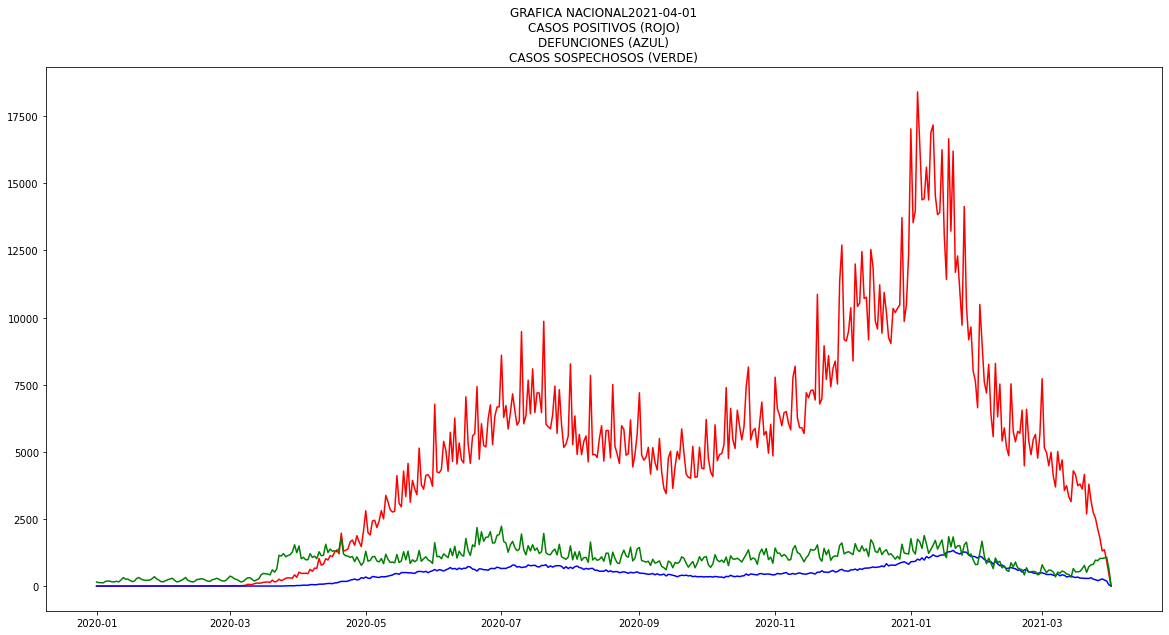

In [74]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL"+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

### Separación de semanas

In [71]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [76]:
cases_by_day.sample(10)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
80,2020-03-21,154,790,517,0,11
415,2021-02-19,5691,16575,636,606,59
379,2021-01-14,13916,21660,1545,1142,54
17,2020-01-18,4,210,185,0,2
238,2020-08-26,4875,6950,1124,508,34
319,2020-11-15,7200,7558,1061,446,45
43,2020-02-13,5,144,155,0,6
206,2020-07-25,7448,6655,1378,746,29
239,2020-08-27,4927,6457,1073,475,34
183,2020-07-02,6278,5562,1660,660,26


In [90]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()
cases_by_week.sample(5)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES
SEMANA,,,,
8,73,1489,1855,1
38,30963,47156,6007,2544
51,73954,102626,8230,5800
31,38878,45333,7863,4587
56,60652,127706,7852,7697


### Mortalidad

In [91]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]
cases_by_week.head(10)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD
SEMANA,,,,,
0,18,965,1075,0,0.000000
1,31,1280,1454,0,0.000000
2,29,1509,1692,0,0.000000
3,20,1419,1787,0,0.000000
4,20,1226,1542,0,0.000000
5,20,1396,1557,1,0.050000
6,42,1237,1531,0,0.000000
7,52,1208,1615,1,0.019231
8,73,1489,1855,1,0.013699


In [101]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])
cases_by_week.head()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
0,18,965,1075,0,0.0,2020-01-01
1,31,1280,1454,0,0.0,2020-01-08
2,29,1509,1692,0,0.0,2020-01-15
3,20,1419,1787,0,0.0,2020-01-22
4,20,1226,1542,0,0.0,2020-01-29


Text(0, 0.5, 'Mortalidad en porcentaje (%)')

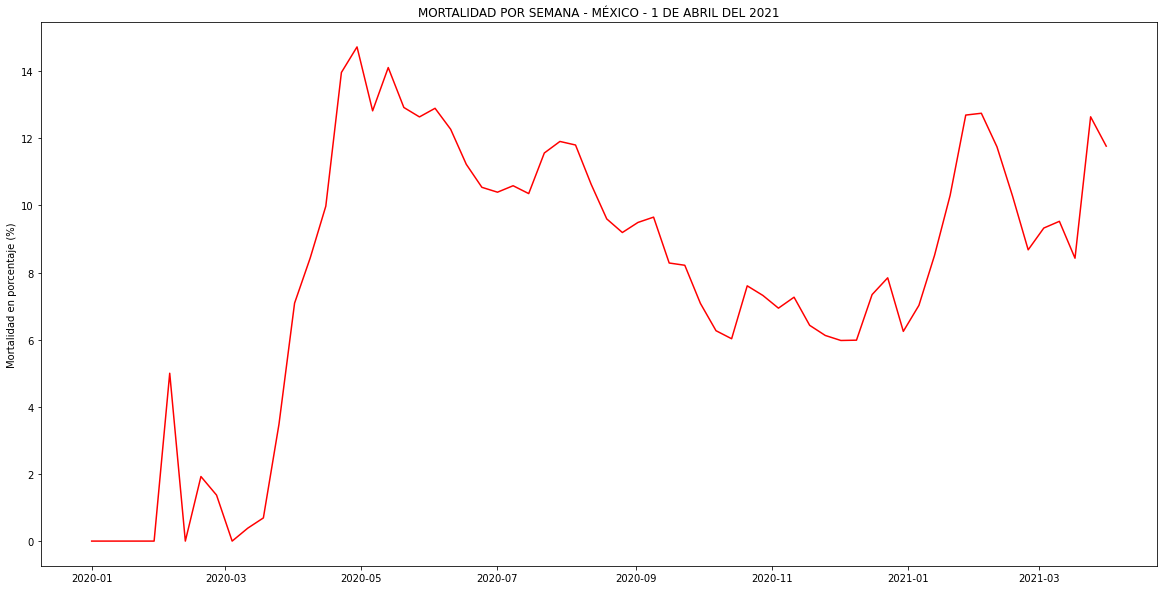

In [111]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA - MÉXICO - 1 DE ABRIL DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

Se puede apreciar que los maximos de la mortalidad coinciden con los picos de las olas que han habido en México.


### Positividad

In [110]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

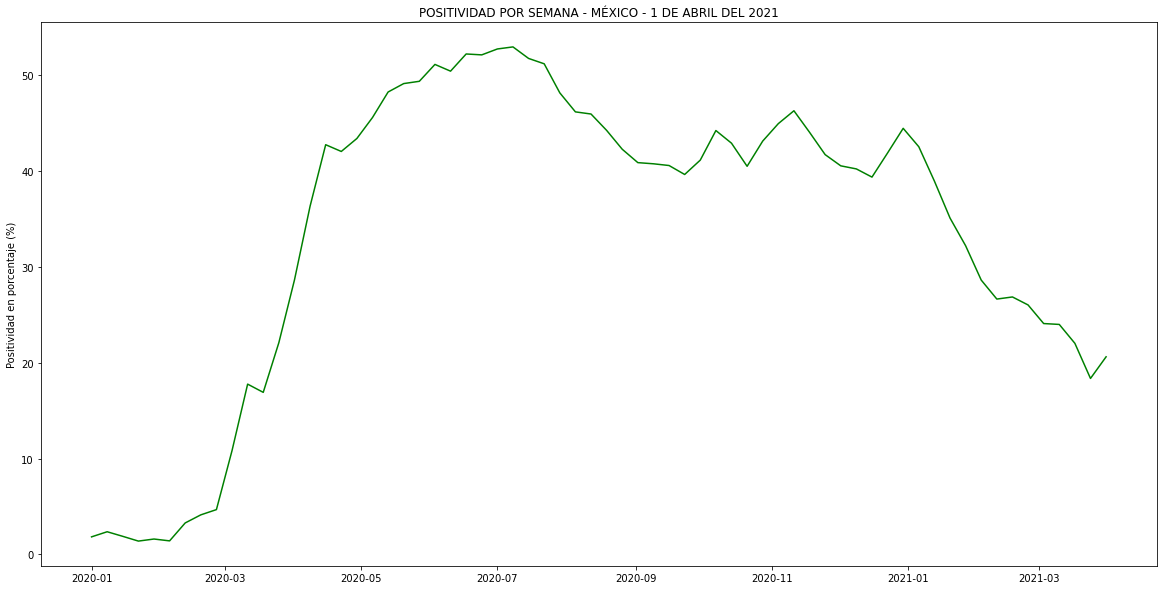

In [112]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA - MÉXICO - 1 DE ABRIL DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

Al igual que con la mortalidad, la positividad cambió durante la pandemia de covid y sus puntos más altos coinciden con los picos de las olas de la epidemia que han habido.

## Guardado Dataset
Se guarda el dataset después de ser limpiado y con datos procesados

In [134]:
dataset_file = "210401COVID19MEXICO_filtered.csv"
data_filtered.to_csv(os.path.join(main_dataset_path, dataset_file))